In [1]:
from packages.data_objects.dataset import TorchH5Dataset, autoencoder_unpack_func
from packages.io.torch_dataloaders import get_data_loaders
dataset = TorchH5Dataset(h5_path='/media/lolly/SSD/motor_eeg_dataset/motor_eeg_dataset.h5', unpack_func=autoencoder_unpack_func)
train_loader, _, _ = get_data_loaders(dataset, norm_axes=(0,2), target_norm_axes=(0,2), norm_convergence_threshold=1e-3, batch_size=64)

Calculating normalization parameters (input & target):  98%|█████████▊| 39/40 [00:02<00:00, 18.71it/s, samples=5120, input_conv=0, target_conv=0]


In [2]:
sample = next(iter(train_loader))['input']
print(sample.shape)

/home/lolly/Projects/MIEEG/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


torch.Size([64, 32, 640])


In [4]:

import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import welch, butter, sosfiltfilt

def test_cwt_reconstruction(head, signal):
    """
    Tests info preservation with Time-Domain (slice) and Frequency-Domain (FULL signal) plots.
    """
    B_in, C, Total_Time = signal.shape
    # Ensure fs is int
    fs = int(getattr(head, 'fs', 160)) 
    
    # 1. Forward Pass
    out = head(signal)
    
    # 2. Automatic Unchunking
    if out.shape[0] != B_in:
        B_out = out.shape[0]
        num_chunks = B_out // B_in
        chunk_time = out.shape[-1]
        _, *feats, _ = out.shape 
        out = out.view(B_in, num_chunks, *feats, chunk_time)
        out = out.permute(0, 2, 3, 4, 5, 1, 6)
        out = out.reshape(B_in, *feats, Total_Time)
        
    # 3. Reconstruct
    valid_pixels = out[:, :, :, head.rows, head.cols, :]
    mag = valid_pixels[:, 0, ...]
    phase = valid_pixels[:, 1, ...]
    complex_cwt = mag * torch.exp(1j * phase)
    
    # --- FIX: FREQUENCY COMPENSATION ---
    # Because we used L2 norm filters, we need to scale by sqrt(Freq) 
    # to recover a flat spectrum in the summation.
    # (Approximate correction factor)
    freqs = torch.tensor(head.frequencies, device=complex_cwt.device).view(1, -1, 1, 1)
    complex_cwt = complex_cwt * torch.sqrt(freqs) 
    
    reconstructed = complex_cwt.real.sum(dim=1)
    
    # 4. Reference & Scaling
    reference_signal = signal - signal.mean(dim=-1, keepdim=True)
    numerator = (reconstructed * reference_signal).sum(dim=-1, keepdim=True)
    denominator = (reconstructed * reconstructed).sum(dim=-1, keepdim=True)
    scale_factor = numerator / (denominator + 1e-8)
    reconstructed *= scale_factor
    
    # 5. MSE
    mse = torch.nn.functional.mse_loss(reconstructed, reference_signal)
    print(f"Reconstruction MSE: {mse.item():.4f}")
    
    # --- PLOTTING ---
    # Move FULL SIGNALS to CPU for plotting
    sig_cpu = reference_signal[0, 0, :].detach().cpu().numpy()
    rec_cpu = reconstructed[0, 0, :].detach().cpu().numpy()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Time Domain (Just a slice to see wiggles)
    display_len = min(200, Total_Time)
    ax1.plot(sig_cpu[:display_len], label="Original", alpha=0.7)
    ax1.plot(rec_cpu[:display_len], '--', label="Reconstructed", alpha=0.7)
    ax1.set_title(f"Time Domain (First {display_len} samples)\nMSE: {mse.item():.4f}")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Frequency Domain (Uses FULL SIGNAL for high res)
    # Use nperseg = Total_Time // 2 or 256, whichever is larger, to get good freq resolution
    nperseg = max(256, len(sig_cpu) // 2)
    nperseg = min(nperseg, len(sig_cpu)) # Cap at signal length
    
    f_orig, p_orig = welch(sig_cpu, fs=fs, nperseg=nperseg)
    f_rec, p_rec = welch(rec_cpu, fs=fs, nperseg=nperseg)
    
    ax2.semilogy(f_orig, p_orig, label="Original PSD", alpha=0.8)
    ax2.semilogy(f_rec, p_rec, '--', label="Reconstructed PSD", alpha=0.8)
    ax2.set_title(f"Frequency Domain (Welch PSD using {len(sig_cpu)} samples)")
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("Power/Frequency (dB/Hz)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Mark CWT Range on Plot
    # Assuming frequencies might be tensor or list
    if isinstance(head.frequencies, torch.Tensor):
        freqs_list = head.frequencies.cpu().numpy()
    else:
        freqs_list = head.frequencies
        
    min_f, max_f = np.min(freqs_list), np.max(freqs_list)
    ax2.axvline(x=min_f, color='r', linestyle=':', alpha=0.5, label='CWT Limits')
    ax2.axvline(x=max_f, color='r', linestyle=':', alpha=0.5)
    
    plt.tight_layout()
    plt.show()


# ============================================================================
# 2. Metrics
# ============================================================================

def calculate_spectral_distortion(sig_orig, sig_recon, fs):
    """Log-Spectral Distance (LSD)"""
    f_orig, p_orig = welch(sig_orig, fs=fs, nperseg=min(256, len(sig_orig)))
    f_rec, p_rec = welch(sig_recon, fs=fs, nperseg=min(256, len(sig_recon)))
    
    eps = 1e-10
    log_p_orig = 10 * np.log10(p_orig + eps)
    log_p_rec = 10 * np.log10(p_rec + eps)
    
    lsd = np.mean((log_p_orig - log_p_rec) ** 2)
    return np.sqrt(lsd)

def calculate_correlation(sig_orig, sig_recon):
    vx = sig_orig - np.mean(sig_orig)
    vy = sig_recon - np.mean(sig_recon)
    return np.sum(vx * vy) / (np.sqrt(np.sum(vx ** 2)) * np.sqrt(np.sum(vy ** 2)))

# ============================================================================
# 3. Reconstruction Logic (Pure Math, no plotting)
# ============================================================================
def run_reconstruction(head, signal):
    """
    Reconstruction logic that properly handles the spatial grid.
    """
    B_in, C, Total_Time = signal.shape
    out = head(signal)
    
    # Handle chunking if present
    if out.shape[0] != B_in:
        B_out = out.shape[0]
        num_chunks = B_out // B_in
        chunk_time = out.shape[-1]
        _, *feats, _ = out.shape 
        out = out.view(B_in, num_chunks, *feats, chunk_time)
        out = out.permute(0, 2, 3, 4, 5, 1, 6)
        out = out.reshape(B_in, *feats, Total_Time)
    
    # Extract valid pixels using the actual channel positions
    # out shape: (B, 2, Freq, H, W, T)
    # Extract at actual channel positions
    valid_pixels = out[:, :, :, head.rows, head.cols, :]  # (B, 2, Freq, C, T)
    
    mag = valid_pixels[:, 0, ...]      # (B, Freq, C, T)
    phase = valid_pixels[:, 1, ...]    # (B, Freq, C, T)
    
    complex_cwt = mag * torch.exp(1j * phase)  # (B, Freq, C, T)
    
    # Frequency compensation
    freqs = torch.tensor(head.frequencies, device=complex_cwt.device).view(1, -1, 1, 1)
    complex_cwt = complex_cwt * torch.sqrt(freqs)
    
    # Sum over frequencies (dim=1) to get (B, C, T)
    reconstructed = complex_cwt.real.sum(dim=1)  # (B, C, T)
    
    # Reference signal
    ref = signal - signal.mean(dim=-1, keepdim=True)  # (B, C, T)
    
    # Scale factor calculation (per channel)
    num = (reconstructed * ref).sum(dim=-1, keepdim=True)      # (B, C, 1)
    den = (reconstructed * reconstructed).sum(dim=-1, keepdim=True)  # (B, C, 1)
    scale = num / (den + 1e-8)
    
    reconstructed *= scale
    
    return reconstructed, ref


def calculate_correlation(sig_orig, sig_recon):
    """Pearson correlation with NaN handling."""
    vx = sig_orig - np.mean(sig_orig)
    vy = sig_recon - np.mean(sig_recon)
    
    # Check for zero variance
    std_x = np.sqrt(np.sum(vx ** 2))
    std_y = np.sqrt(np.sum(vy ** 2))
    
    if std_x < 1e-10 or std_y < 1e-10:
        return 0.0  # Return 0 instead of NaN for zero variance
    
    return np.sum(vx * vy) / (std_x * std_y)


def find_optimal_frequencies(n_samples=10, n_channels=8):
    """
    Test with multiple samples and channels for robust statistics.
    
    Args:
        n_samples: Number of independent signals to test
        n_channels: Number of channels per sample
    """
    print(f"Generating {n_samples} Synthetic Signals with {n_channels} channels each...")
    fs = 160
    T = 640
    
    # Generate multiple samples with multiple channels
    all_signals = []
    for _ in range(n_samples):
        # Generate 1/f noise for all channels
        white = np.random.randn(1, n_channels, T)
        fft = np.fft.rfft(white, axis=-1)
        freqs_fft = np.fft.rfftfreq(T)
        fft[:, :, 1:] /= np.sqrt(freqs_fft[1:])
        pink = np.fft.irfft(fft, n=T, axis=-1)
        
        # Bandpass filter
        sos = butter(4, [0.5, 79.9], btype='bandpass', fs=fs, output='sos')
        signal_np = sosfiltfilt(sos, pink, axis=-1)
        
        # Normalize
        signal_np = signal_np / (np.std(signal_np, axis=-1, keepdims=True) + 1e-8)
        
        all_signals.append(signal_np)
    
    # Stack all samples: (n_samples, n_channels, T)
    all_signals = np.concatenate(all_signals, axis=0)
    signal = torch.from_numpy(all_signals).float()
    
    print(f"Signal shape: {signal.shape}")
    print(f"Signal mean: {signal.mean().item():.4f}, std: {signal.std().item():.4f}")
    
    results = {'n': [], 'mse': [], 'mse_std': [], 'lsd': [], 'lsd_std': [], 'corr': [], 'corr_std': []}
    freq_counts = [4, 8, 10, 12, 16, 24, 32, 40, 48, 56, 64]
    
    print(f"\n{'N':<5} | {'MSE':<12} | {'LSD':<12} | {'Corr':<12}")
    print("-" * 50)
    
    for n in freq_counts:
        # Setup Model
        f_list = np.logspace(np.log10(0.5), np.log10(80), n)
        
        model = CWTHead(
            frequencies=f_list, 
            fs=fs, 
            num_channels=n_channels, 
            n_cycles=6.0,
            trainable=False
        )
        
        # Run reconstruction
        rec, ref = run_reconstruction(model, signal)
        
        # Calculate metrics per sample and channel
        mse_vals = []
        lsd_vals = []
        corr_vals = []
        
        for sample_idx in range(n_samples):
            for ch_idx in range(n_channels):
                ref_np = ref[sample_idx, ch_idx].detach().numpy()
                rec_np = rec[sample_idx, ch_idx].detach().numpy()
                
                # MSE
                mse = np.mean((ref_np - rec_np) ** 2)
                mse_vals.append(mse)
                
                # LSD
                lsd = calculate_spectral_distortion(ref_np, rec_np, fs)
                lsd_vals.append(lsd)
                
                # Correlation
                corr = calculate_correlation(ref_np, rec_np)
                corr_vals.append(corr)
        
        # Statistics across all samples and channels
        mse_mean = np.mean(mse_vals)
        mse_std = np.std(mse_vals)
        lsd_mean = np.mean(lsd_vals)
        lsd_std = np.std(lsd_vals)
        corr_mean = np.mean(corr_vals)
        corr_std = np.std(corr_vals)
        
        print(f"{n:<5} | {mse_mean:.4f}±{mse_std:.4f} | {lsd_mean:.4f}±{lsd_std:.4f} | {corr_mean:.4f}±{corr_std:.4f}")
        
        results['n'].append(n)
        results['mse'].append(mse_mean)
        results['mse_std'].append(mse_std)
        results['lsd'].append(lsd_mean)
        results['lsd_std'].append(lsd_std)
        results['corr'].append(corr_mean)
        results['corr_std'].append(corr_std)
    
    # Plotting with error bars
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # MSE with error bars
    axes[0].errorbar(results['n'], results['mse'], yerr=results['mse_std'], 
                     fmt='o-', capsize=5, capthick=2)
    axes[0].set_title(f"MSE vs Number of Frequencies\n({n_samples} samples × {n_channels} channels)")
    axes[0].set_xlabel("N Frequencies")
    axes[0].set_ylabel("MSE")
    axes[0].grid(True, alpha=0.3)
    
    # LSD with error bars
    axes[1].errorbar(results['n'], results['lsd'], yerr=results['lsd_std'],
                     fmt='o-', color='orange', capsize=5, capthick=2)
    axes[1].set_title("Log-Spectral Distance")
    axes[1].set_xlabel("N Frequencies")
    axes[1].set_ylabel("LSD (dB)")
    axes[1].grid(True, alpha=0.3)
    
    # Correlation with error bars
    axes[2].errorbar(results['n'], results['corr'], yerr=results['corr_std'],
                     fmt='o-', color='green', capsize=5, capthick=2)
    axes[2].set_title("Correlation")
    axes[2].set_xlabel("N Frequencies")
    axes[2].set_ylabel("Pearson r")
    axes[2].grid(True, alpha=0.3)
    axes[2].set_ylim([0, 1.05])
    
    plt.tight_layout()
    plt.show()
    
    # Find elbow point using mean values
    mse_array = np.array(results['mse'])
    n_array = np.array(results['n'])
    
    # Normalized improvements
    mse_norm = (mse_array - mse_array.min()) / (mse_array.max() - mse_array.min() + 1e-8)
    improvements = np.diff(mse_norm)
    
    # Find where improvement drops below threshold
    threshold = 0.05
    elbow_idx = np.where(np.abs(improvements) < threshold)[0]
    
    if len(elbow_idx) > 0:
        elbow_n = n_array[elbow_idx[0] + 1]
        print(f"\nRecommended number of frequencies (elbow point): {elbow_n}")
    else:
        print(f"\nNo clear elbow found. Consider using {n_array[len(n_array)//2]} frequencies.")
    
    # Print summary statistics
    print(f"\n{'='*60}")
    print(f"SUMMARY STATISTICS ({n_samples*n_channels} total measurements)")
    print(f"{'='*60}")
    for i, n in enumerate(results['n']):
        print(f"N={n:3d}: MSE={results['mse'][i]:.4f}±{results['mse_std'][i]:.4f}, "
              f"LSD={results['lsd'][i]:.4f}±{results['lsd_std'][i]:.4f}, "
              f"Corr={results['corr'][i]:.4f}±{results['corr_std'][i]:.4f}")
    
    return results


# if __name__ == "__main__":

#     find_optimal_frequencies(n_samples=100, n_channels=32)

In [9]:
import numpy as np
from packages.models.wavelet_head import CWTHead
frequencies = np.logspace(np.log10(0.5), np.log10(79.9), 25)
cwt_head = CWTHead(frequencies=frequencies, fs=160, chunk_samples=160)
frequencies

array([ 0.5       ,  0.61771152,  0.76313505,  0.94279463,  1.16475022,
        1.43895926,  1.77772344,  2.19624051,  2.71328614,  3.35205623,
        4.14120752,  5.11614321,  6.32060124,  7.80861644,  9.64694472,
       11.91805784, 14.72384333, 18.19017539, 22.47256191, 27.76312091,
       34.29919944, 42.37402148, 52.34984274, 64.67420224, 79.9       ])

Reconstruction MSE: 0.0452


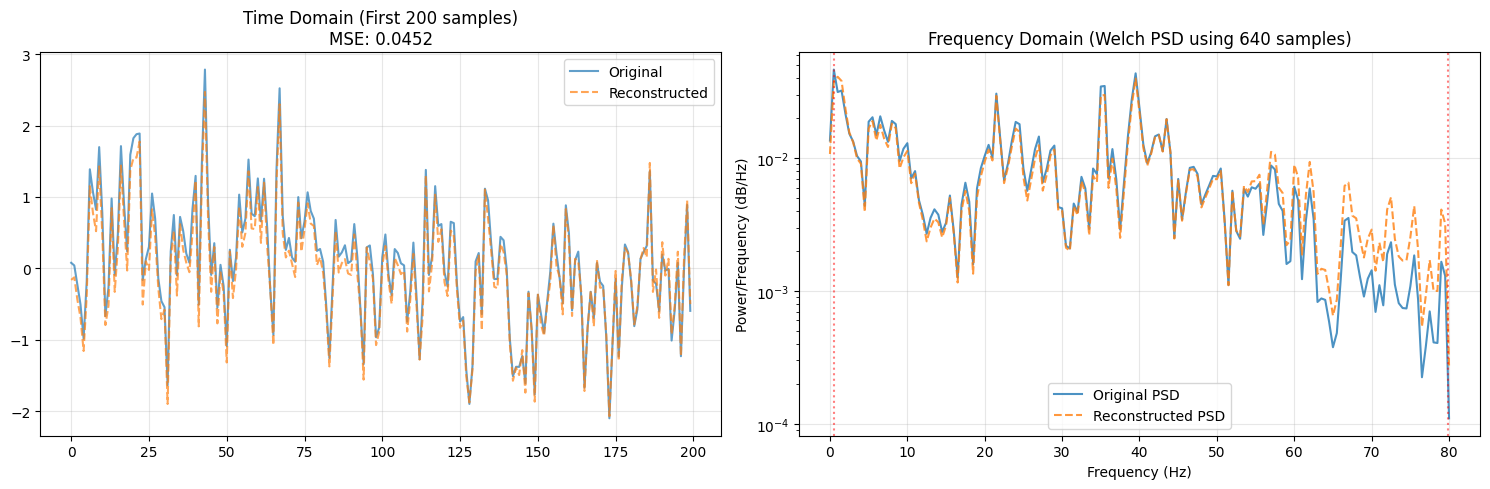

Reconstruction MSE: 0.0274


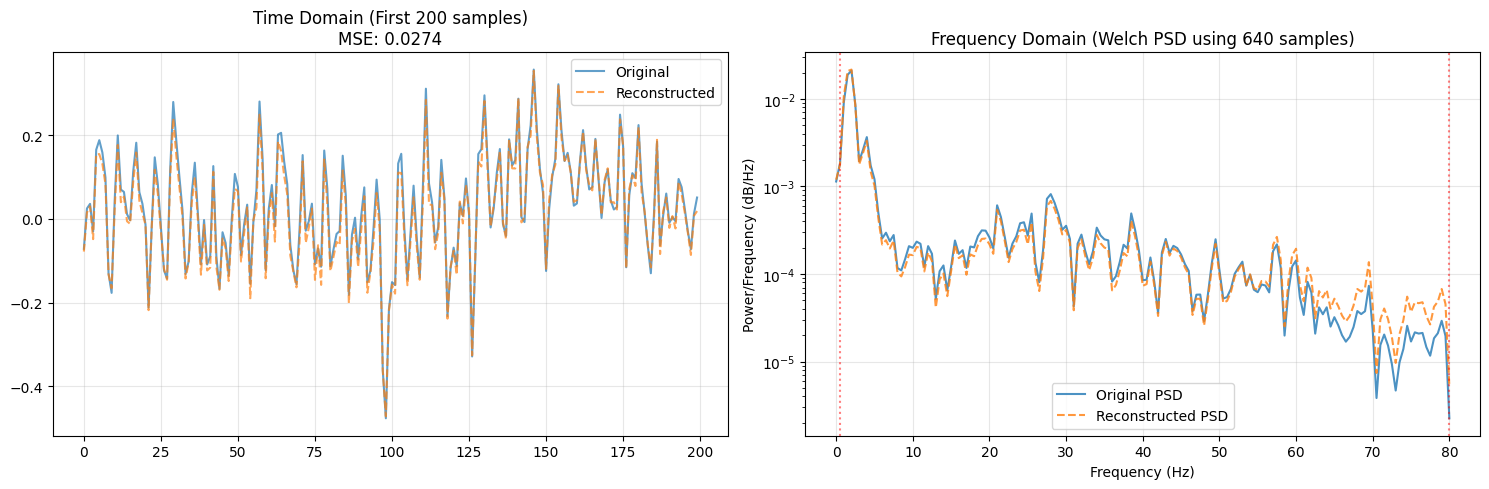

Reconstruction MSE: 0.0467


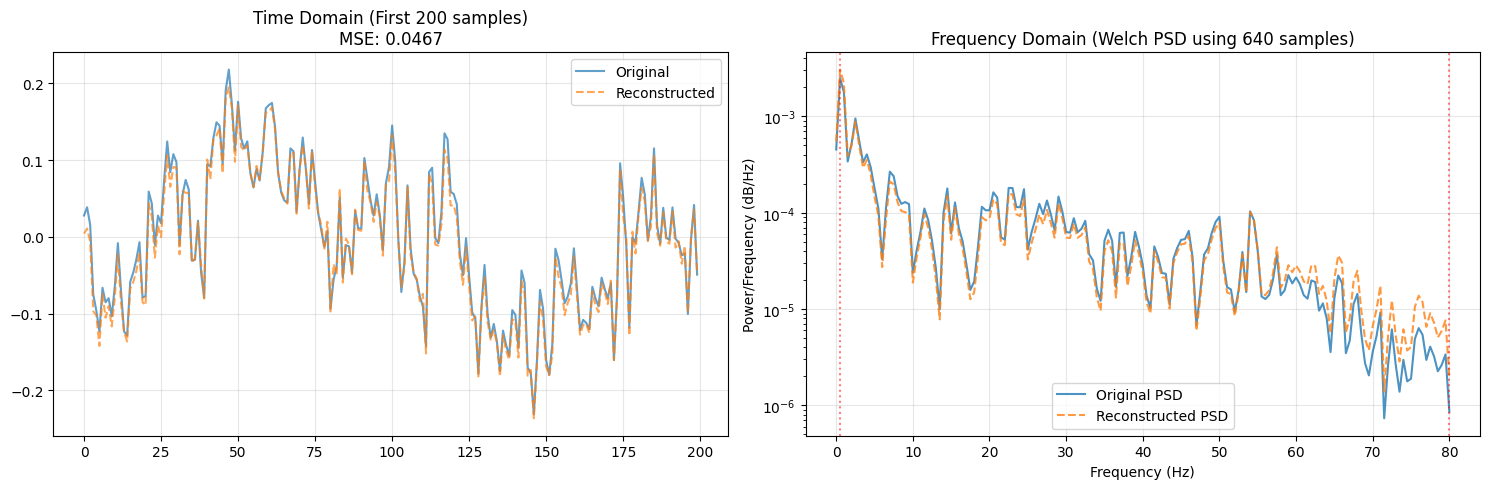

In [ ]:
sample = next(iter(train_loader))['input']
test_cwt_reconstruction(cwt_head, sample)
sample = next(iter(train_loader))['input']
test_cwt_reconstruction(cwt_head, sample)
sample = next(iter(train_loader))['input']
test_cwt_reconstruction(cwt_head, sample)

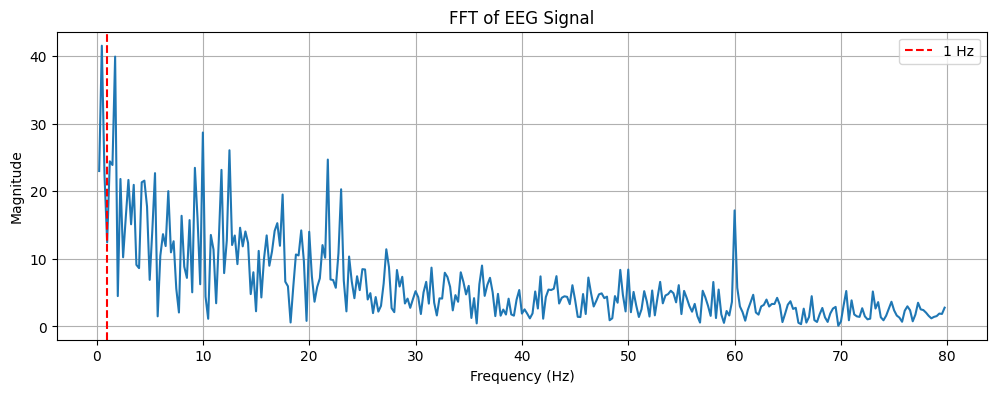

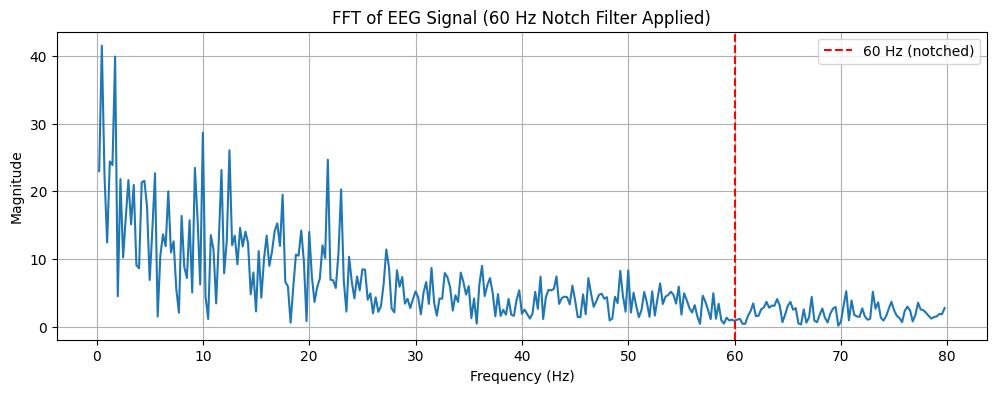

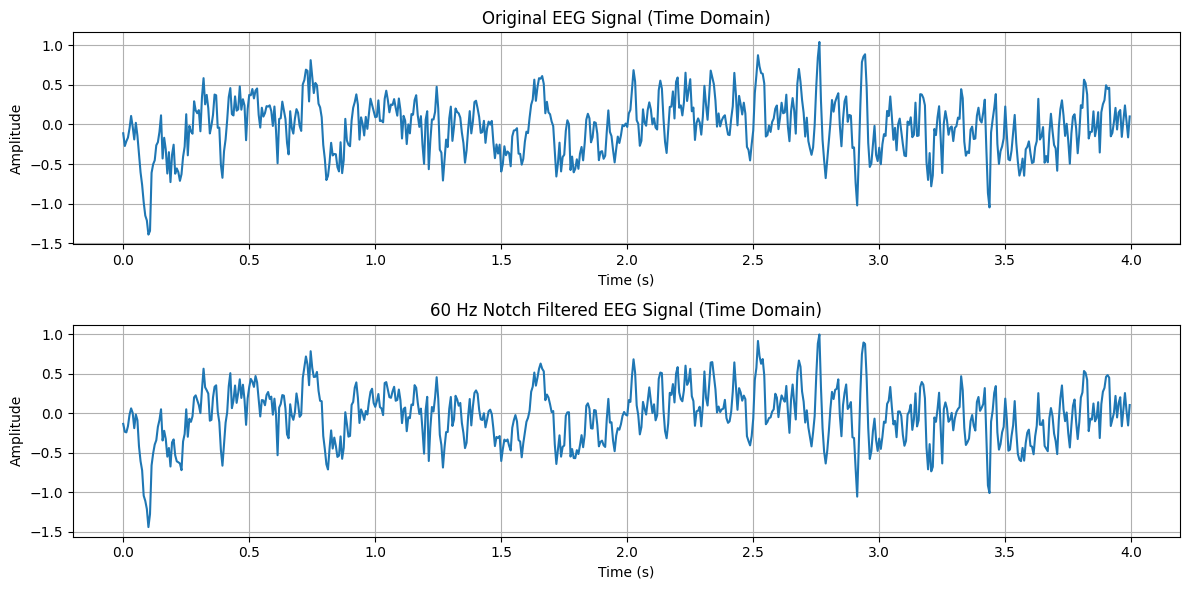

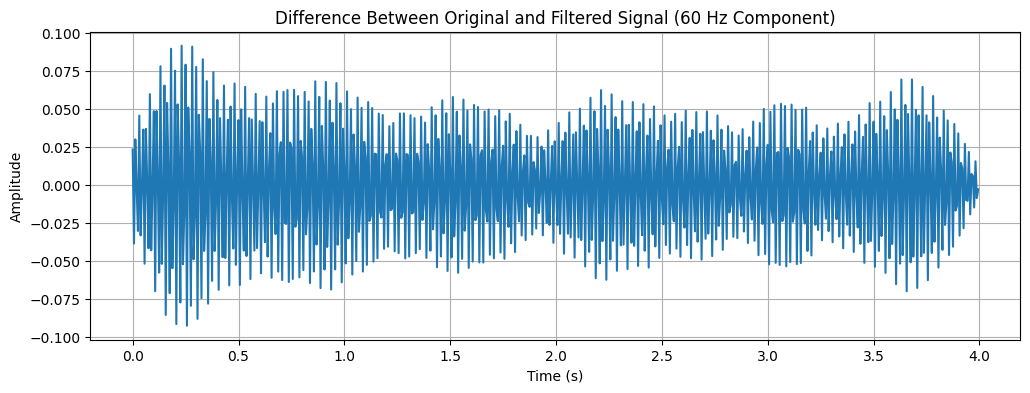

Difference statistics:
  Mean: 0.000001
  Std: 0.039954
  Min: -0.092374
  Max: 0.091449


In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import iirnotch, filtfilt

sample = next(iter(train_loader))['input']
# Get a single sample and compute FFT
sample_data = sample[0, 0, :].cpu().numpy()  # Take first batch, first channel
fft_values = np.fft.fft(sample_data)
fft_freq = np.fft.fftfreq(len(sample_data), 1/160)  # fs=160 from cwt_head

# Plot only positive frequencies
positive_freq_idx = fft_freq > 0

# Create figure FIRST
plt.figure(figsize=(12, 4))

# Plot FFT
plt.plot(fft_freq[positive_freq_idx], np.abs(fft_values[positive_freq_idx]))

# Add vertical line at 1 Hz AFTER creating figure
plt.axvline(x=1, color='red', linestyle='--', label='1 Hz')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT of EEG Signal')
plt.legend()
plt.grid(True)
plt.show()

# Apply notch filter at 60 Hz

# Design notch filter for 60 Hz
fs = 160
f0 = 60.0  # Frequency to remove
Q = 30.0  # Quality factor
b, a = iirnotch(f0, Q, fs)

# Apply filter
filtered_data = filtfilt(b, a, sample_data)

# Compute FFT of filtered signal
fft_filtered = np.fft.fft(filtered_data)

# Plot filtered FFT
plt.figure(figsize=(12, 4))
plt.plot(fft_freq[positive_freq_idx], np.abs(fft_filtered[positive_freq_idx]))
plt.axvline(x=60, color='red', linestyle='--', label='60 Hz (notched)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT of EEG Signal (60 Hz Notch Filter Applied)')
plt.legend()
plt.grid(True)
plt.show()


# Plot time series comparison
plt.figure(figsize=(12, 6))

# Create time axis
time_axis = np.arange(len(sample_data)) / fs

# Plot original signal
plt.subplot(2, 1, 1)
plt.plot(time_axis, sample_data)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original EEG Signal (Time Domain)')
plt.grid(True)

# Plot filtered signal
plt.subplot(2, 1, 2)
plt.plot(time_axis, filtered_data)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('60 Hz Notch Filtered EEG Signal (Time Domain)')
plt.grid(True)

plt.tight_layout()
plt.show()


# Plot sample-wise difference between original and filtered signals
plt.figure(figsize=(12, 4))
difference = sample_data - filtered_data
plt.plot(time_axis, difference)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Difference Between Original and Filtered Signal (60 Hz Component)')
plt.grid(True)
plt.show()

# Show statistics of the difference
print(f"Difference statistics:")
print(f"  Mean: {np.mean(difference):.6f}")
print(f"  Std: {np.std(difference):.6f}")
print(f"  Min: {np.min(difference):.6f}")
print(f"  Max: {np.max(difference):.6f}")

torch.Size([256, 2, 25, 7, 5, 160])


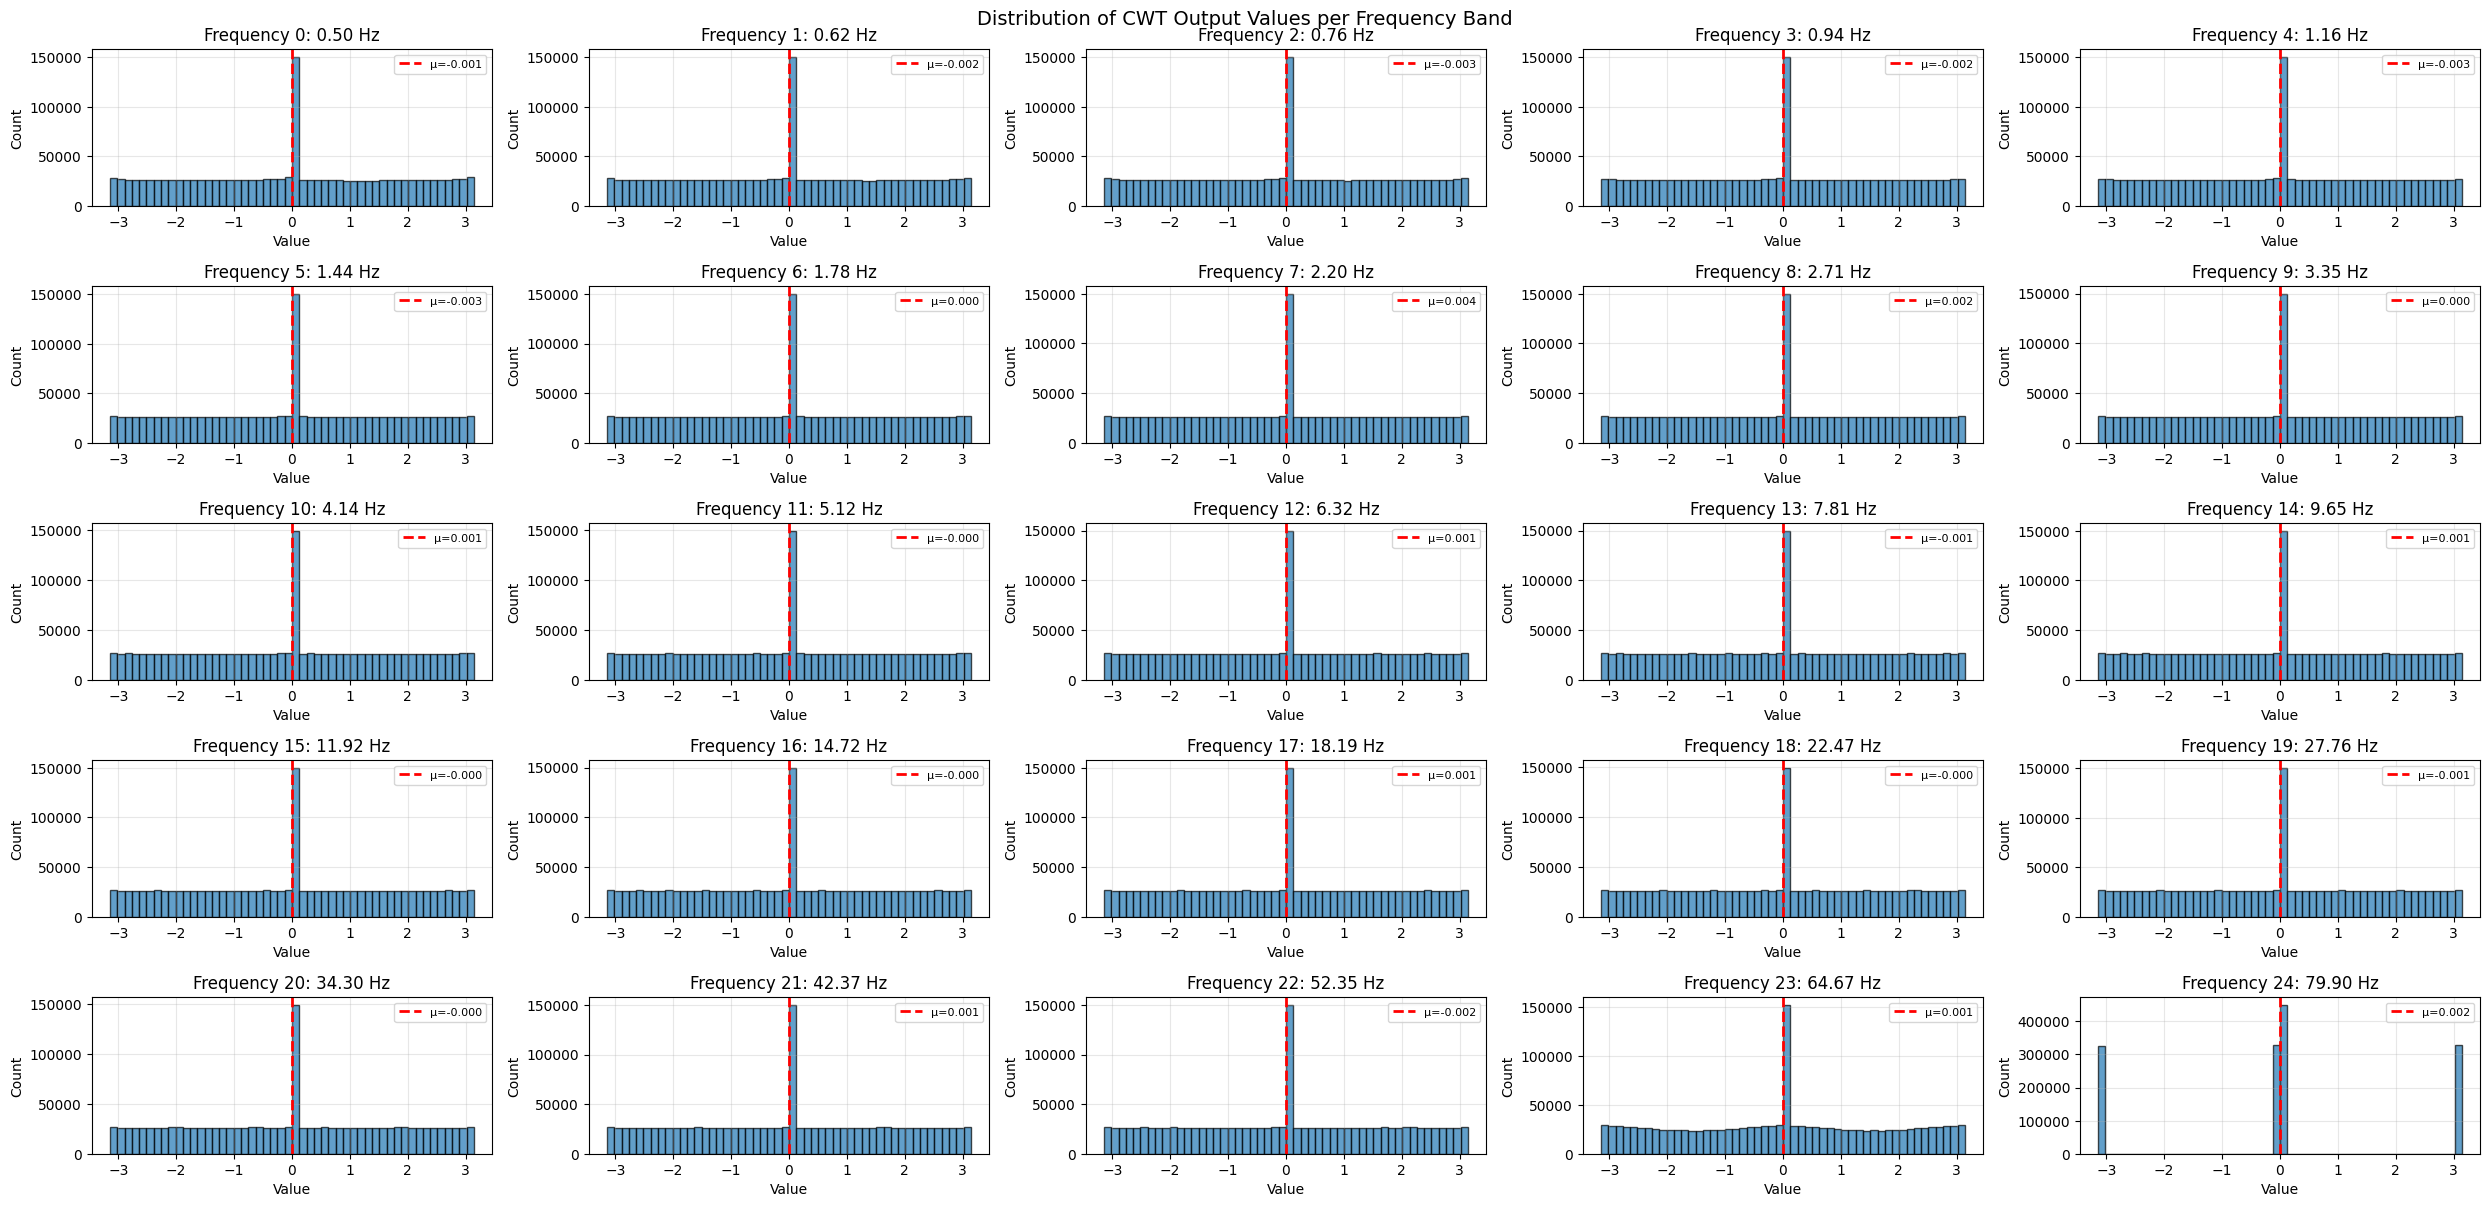


Summary Statistics per Frequency Band:
Freq (Hz)    | Mean       | Std        | Min        | Max       
------------------------------------------------------------
0.50         | -0.0008    | 1.7398     | -3.1416    | 3.1416    
0.62         | -0.0017    | 1.7390     | -3.1416    | 3.1416    
0.76         | -0.0031    | 1.7384     | -3.1416    | 3.1416    
0.94         | -0.0023    | 1.7377     | -3.1416    | 3.1416    
1.16         | -0.0027    | 1.7352     | -3.1416    | 3.1416    
1.44         | -0.0033    | 1.7360     | -3.1416    | 3.1416    
1.78         | 0.0002     | 1.7365     | -3.1416    | 3.1416    
2.20         | 0.0037     | 1.7359     | -3.1416    | 3.1416    
2.71         | 0.0018     | 1.7361     | -3.1416    | 3.1416    
3.35         | 0.0001     | 1.7350     | -3.1416    | 3.1416    
4.14         | 0.0010     | 1.7349     | -3.1416    | 3.1416    
5.12         | -0.0002    | 1.7354     | -3.1416    | 3.1416    
6.32         | 0.0007     | 1.7356     | -3.1416    | 

In [20]:
# Get CWT output
out = cwt_head(sample)
print(out.shape)
freq_dim = 2
# Plot distributions for each frequency band (dim=-2)
fig, axes = plt.subplots(5, 5, figsize=(25, 12))
axes = axes.flatten()

for i in range(out.shape[freq_dim]):
    # Get all values for this frequency band
    values = out[:, 1, i, :, :, :].detach().cpu().numpy().flatten()
    
    # Plot histogram
    axes[i].hist(values, bins=50, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Frequency {i}: {frequencies[i]:.2f} Hz')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Count')
    axes[i].grid(True, alpha=0.3)
    
    # Add statistics
    mean_val = np.mean(values)
    std_val = np.std(values)
    axes[i].axvline(mean_val, color='r', linestyle='--', linewidth=2, label=f'μ={mean_val:.3f}')
    axes[i].legend(fontsize=8)

plt.tight_layout()
plt.suptitle('Distribution of CWT Output Values per Frequency Band', y=1.002, fontsize=14)
plt.show()

# Print summary statistics
print("\nSummary Statistics per Frequency Band:")
print(f"{'Freq (Hz)':<12} | {'Mean':<10} | {'Std':<10} | {'Min':<10} | {'Max':<10}")
print("-" * 60)
for i in range(out.shape[freq_dim]):
    values = out[:, 1, i, :, :].detach().cpu().numpy().flatten()
    print(f"{frequencies[i]:<12.2f} | {np.mean(values):<10.4f} | {np.std(values):<10.4f} | {np.min(values):<10.4f} | {np.max(values):<10.4f}")

All coefficients shape: (2048, 25, 640)
All magnitudes shape: (2048, 25, 640)
All phases shape: (2048, 25, 640)
Combined output shape: (2048, 2, 25, 640)


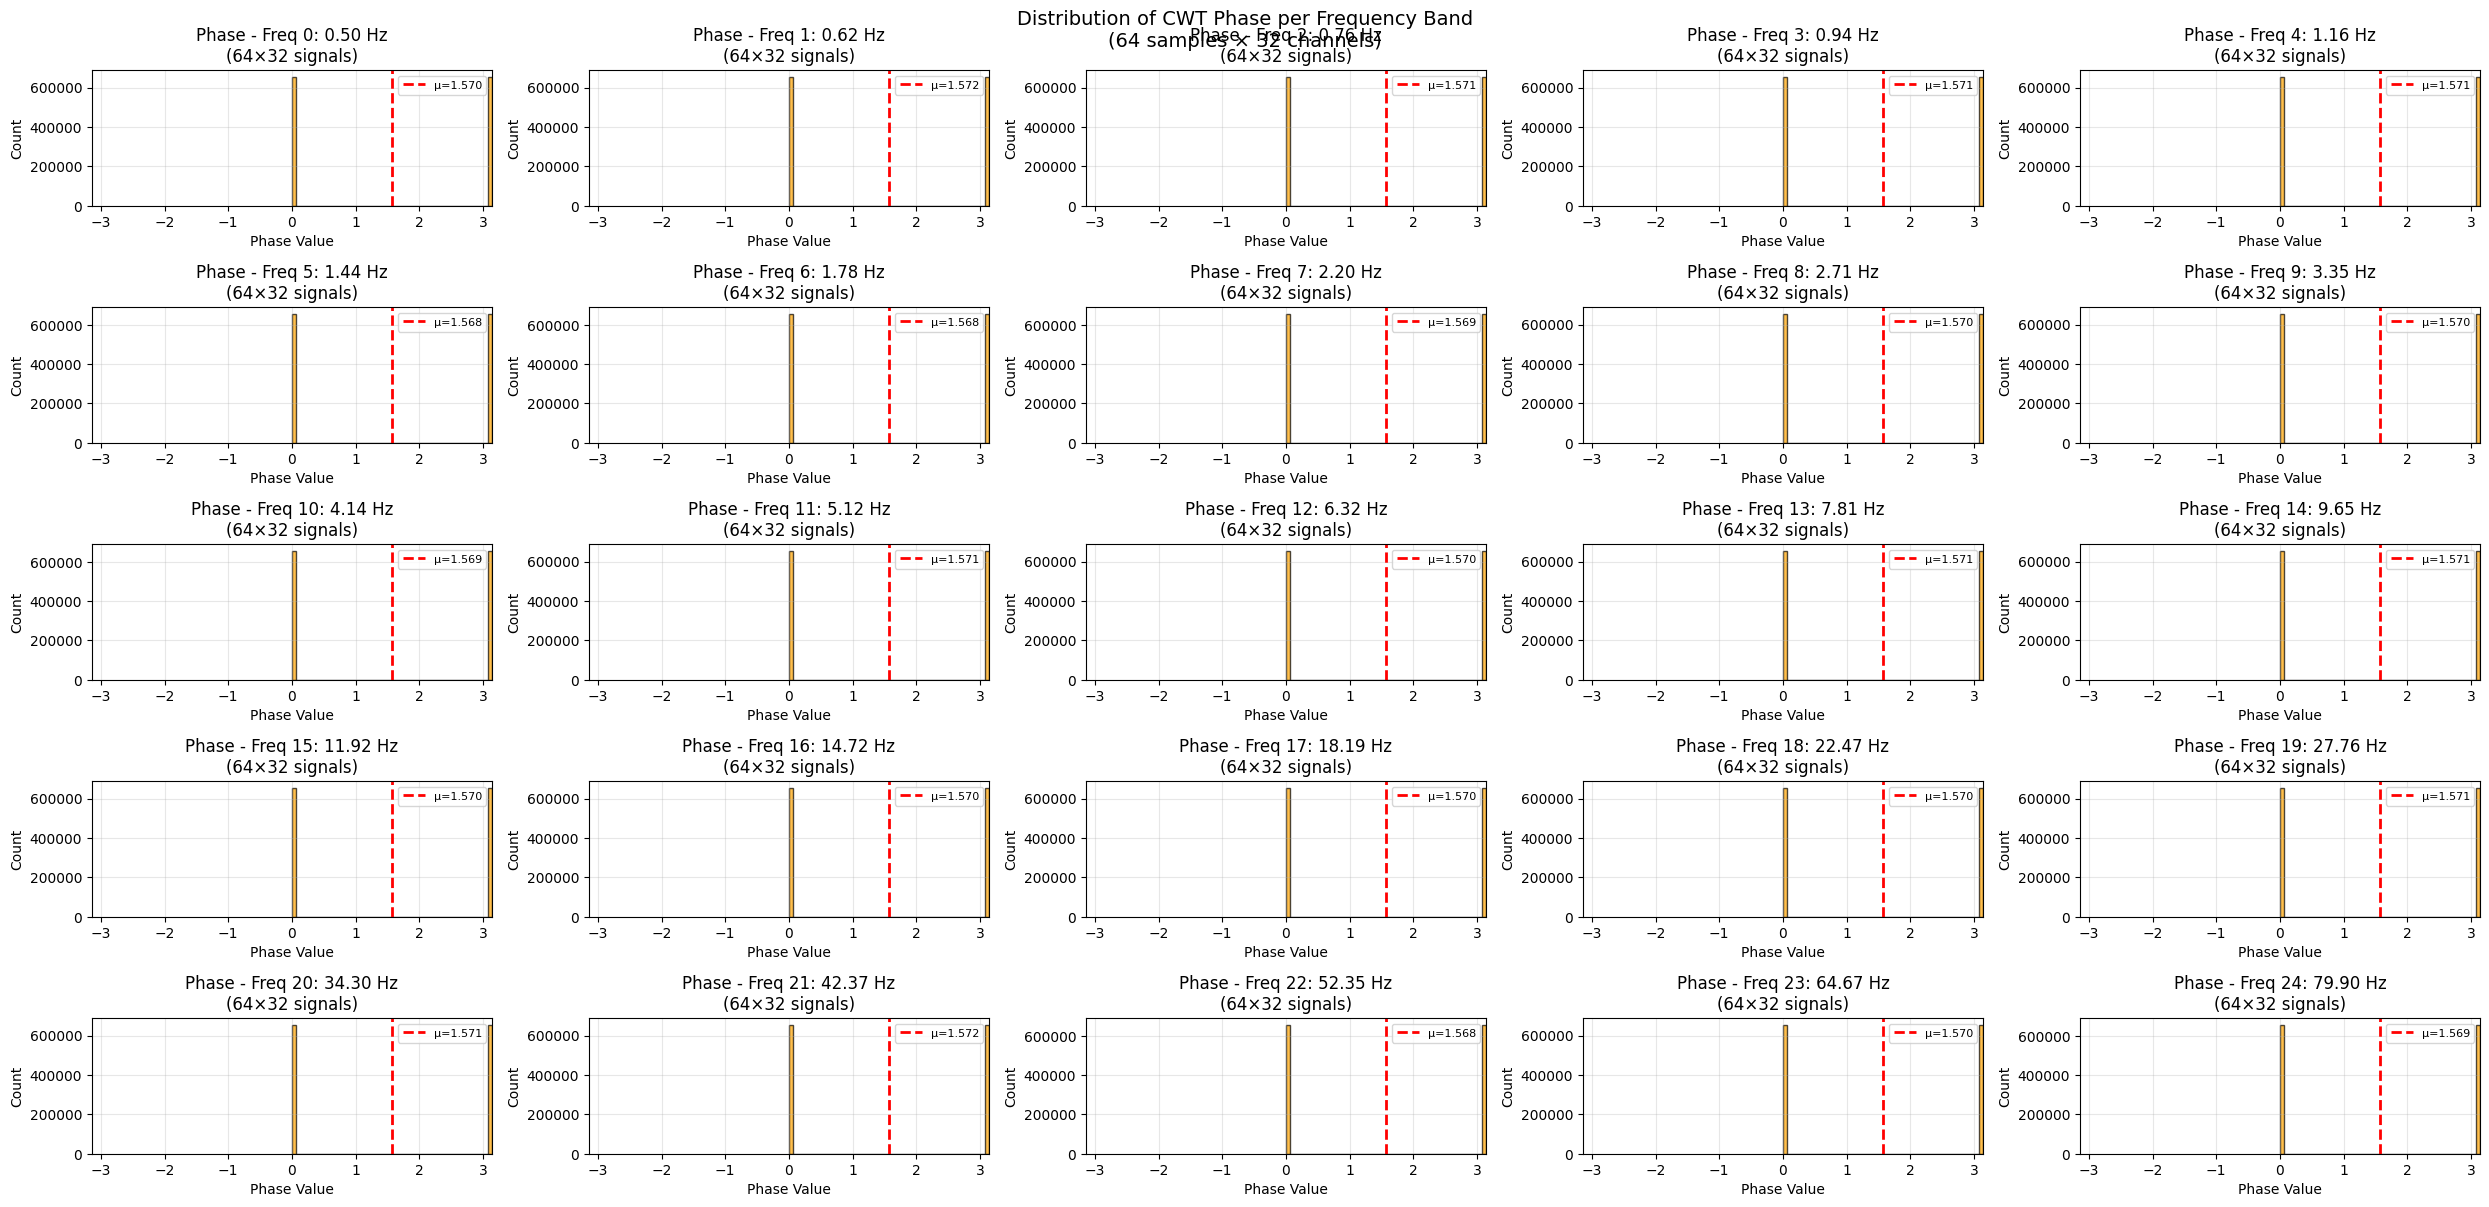


Phase Statistics per Frequency Band (across 2048 signals):
Freq (Hz)    | Mean       | Std        | Min        | Max       
------------------------------------------------------------
0.50         | 1.5704     | 1.5708     | 0.0000     | 3.1416    
0.62         | 1.5718     | 1.5708     | 0.0000     | 3.1416    
0.76         | 1.5712     | 1.5708     | 0.0000     | 3.1416    
0.94         | 1.5714     | 1.5708     | 0.0000     | 3.1416    
1.16         | 1.5712     | 1.5708     | 0.0000     | 3.1416    
1.44         | 1.5677     | 1.5708     | 0.0000     | 3.1416    
1.78         | 1.5680     | 1.5708     | 0.0000     | 3.1416    
2.20         | 1.5693     | 1.5708     | 0.0000     | 3.1416    
2.71         | 1.5699     | 1.5708     | 0.0000     | 3.1416    
3.35         | 1.5702     | 1.5708     | 0.0000     | 3.1416    
4.14         | 1.5694     | 1.5708     | 0.0000     | 3.1416    
5.12         | 1.5714     | 1.5708     | 0.0000     | 3.1416    
6.32         | 1.5704     | 1.5708

In [ ]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
import torch

# Parameters
fs = 160  # Sampling frequency
frequencies = np.logspace(np.log10(0.5), np.log10(79.9), 25)
scales = pywt.frequency2scale('morl', frequencies / fs)

batch_size, n_channels, time_samples = sample.shape

# Apply CWT to all samples and channels
all_coefficients = []
all_magnitudes = []
all_phases = []

for b in range(batch_size):
    for c in range(n_channels):
        sample_data = sample[b, c, :].cpu().numpy()  # (time,)
        
        # Compute CWT
        coefficients, freqs_cwt = pywt.cwt(
            sample_data, 
            scales=scales, 
            wavelet='morl',
            sampling_period=1/fs
        )
        
        # Get magnitude and phase
        magnitude = np.abs(coefficients)
        phase = torch.atan2(torch.imag(torch.tensor(coefficients)), torch.real(torch.tensor(coefficients))).numpy()
        
        all_coefficients.append(coefficients)
        all_magnitudes.append(magnitude)
        all_phases.append(phase)

# Stack all results: (batch*channels, n_frequencies, time)
all_coefficients = np.stack(all_coefficients, axis=0)
all_magnitudes = np.stack(all_magnitudes, axis=0)
all_phases = np.stack(all_phases, axis=0)

print(f"All coefficients shape: {all_coefficients.shape}")
print(f"All magnitudes shape: {all_magnitudes.shape}")
print(f"All phases shape: {all_phases.shape}")

# Stack magnitude and phase into format: (batch*channels, 2, n_freq, time)
out = np.stack([all_magnitudes, all_phases], axis=1)
print(f"Combined output shape: {out.shape}")

# ============================================================================
# PLOT DISTRIBUTIONS - WITH TOGGLE
# ============================================================================

# ⭐ TOGGLE HERE: 'magnitude', 'phase', or 'both'
plot_type = 'phase'  # Options: 'magnitude', 'phase', 'both'

freq_dim = 2  # Frequency is at dimension 2

if plot_type in ['magnitude', 'phase']:
    # Single plot (magnitude OR phase)
    fig, axes = plt.subplots(5, 5, figsize=(25, 12))
    axes = axes.flatten()
    
    # Select which component to plot
    component_idx = 0 if plot_type == 'magnitude' else 1
    component_name = 'Magnitude' if plot_type == 'magnitude' else 'Phase'
    
    for i in range(out.shape[freq_dim]):
        # Get values for this frequency band
        values = out[:, component_idx, i, :].flatten()
        
        # Plot histogram
        color = 'blue' if plot_type == 'magnitude' else 'orange'
        axes[i].hist(values, bins=50, alpha=0.7, edgecolor='black', color=color)
        axes[i].set_title(f'{component_name} - Freq {i}: {freqs_cwt[i]:.2f} Hz\n({batch_size}×{n_channels} signals)')
        axes[i].set_xlabel(f'{component_name} Value')
        axes[i].set_ylabel('Count')
        axes[i].grid(True, alpha=0.3)
        
        # Add statistics
        mean_val = np.mean(values)
        std_val = np.std(values)
        axes[i].axvline(mean_val, color='r', linestyle='--', linewidth=2, label=f'μ={mean_val:.3f}')
        axes[i].legend(fontsize=8)
        
        # For phase, set x-axis limits to [-π, π]
        if plot_type == 'phase':
            axes[i].set_xlim([-np.pi, np.pi])
    
    plt.tight_layout()
    plt.suptitle(f'Distribution of CWT {component_name} per Frequency Band\n({batch_size} samples × {n_channels} channels)', 
                 y=1.002, fontsize=14)
    plt.show()
    
    # Print summary statistics
    print(f"\n{component_name} Statistics per Frequency Band (across {batch_size*n_channels} signals):")
    print(f"{'Freq (Hz)':<12} | {'Mean':<10} | {'Std':<10} | {'Min':<10} | {'Max':<10}")
    print("-" * 60)
    for i in range(out.shape[freq_dim]):
        values = out[:, component_idx, i, :].flatten()
        print(f"{freqs_cwt[i]:<12.2f} | {np.mean(values):<10.4f} | {np.std(values):<10.4f} | {np.min(values):<10.4f} | {np.max(values):<10.4f}")

elif plot_type == 'both':
    # Side-by-side plots (magnitude AND phase)
    fig, axes = plt.subplots(5, 10, figsize=(40, 12))  # 5 rows, 10 cols (5 freqs × 2 components)
    
    for i in range(min(25, out.shape[freq_dim])):
        row = i // 5
        col_offset = (i % 5) * 2
        
        # --- MAGNITUDE ---
        mag_values = out[:, 0, i, :].flatten()
        ax_mag = axes[row, col_offset]
        ax_mag.hist(mag_values, bins=50, alpha=0.7, edgecolor='black', color='blue')
        ax_mag.set_title(f'Mag - {freqs_cwt[i]:.2f} Hz', fontsize=9)
        ax_mag.set_xlabel('Magnitude', fontsize=8)
        ax_mag.set_ylabel('Count', fontsize=8)
        ax_mag.grid(True, alpha=0.3)
        
        mean_mag = np.mean(mag_values)
        ax_mag.axvline(mean_mag, color='r', linestyle='--', linewidth=1.5, label=f'μ={mean_mag:.2f}')
        ax_mag.legend(fontsize=7)
        
        # --- PHASE ---
        phase_values = out[:, 1, i, :].flatten()
        ax_phase = axes[row, col_offset + 1]
        ax_phase.hist(phase_values, bins=50, alpha=0.7, edgecolor='black', color='orange')
        ax_phase.set_title(f'Phase - {freqs_cwt[i]:.2f} Hz', fontsize=9)
        ax_phase.set_xlabel('Phase (rad)', fontsize=8)
        ax_phase.set_ylabel('Count', fontsize=8)
        ax_phase.grid(True, alpha=0.3)
        ax_phase.set_xlim([-np.pi, np.pi])
        
        mean_phase = np.mean(phase_values)
        ax_phase.axvline(mean_phase, color='r', linestyle='--', linewidth=1.5, label=f'μ={mean_phase:.2f}')
        ax_phase.legend(fontsize=7)
    
    plt.tight_layout()
    plt.suptitle(f'CWT Magnitude & Phase Distributions per Frequency Band\n({batch_size} samples × {n_channels} channels)', 
                 y=1.0, fontsize=14)
    plt.show()
    
    # Print combined statistics
    print(f"\nCombined Statistics per Frequency Band (across {batch_size*n_channels} signals):")
    print(f"{'Freq (Hz)':<12} | {'Mag Mean':<10} | {'Mag Std':<10} | {'Phase Mean':<10} | {'Phase Std':<10}")
    print("-" * 70)
    for i in range(out.shape[freq_dim]):
        mag_vals = out[:, 0, i, :].flatten()
        phase_vals = out[:, 1, i, :].flatten()
        print(f"{freqs_cwt[i]:<12.2f} | {np.mean(mag_vals):<10.4f} | {np.std(mag_vals):<10.4f} | {np.mean(phase_vals):<10.4f} | {np.std(phase_vals):<10.4f}")

else:
    print(f"Invalid plot_type: '{plot_type}'. Choose 'magnitude', 'phase', or 'both'.")